# Case Study Overview

**Yourcabs.com** faces a critical business issue: *drivers frequently cancel scheduled rides, leaving customers stranded and dissatisfied.* 


Using historical booking data, your task is to build a predictive model to classify rides as **"cancelled"** or **"not cancelled."**

# Importing required packages

In [1]:
# For performing operation on dataframe
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# For Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix

# Importing objects to build NN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# For visualization
import seaborn as sns
import matplotlib.pyplot as plt

### Reading the data file

In [2]:
taxi_df = pd.read_csv("Taxi-cancellation-case.csv")

In [3]:
taxi_df.head(10)

,row#,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,to_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation
0,1,17712,12,NaN,2,1021.0,1323.0,NaN,NaN,1/1/13 22:33,NaN,0,0,1/1/13 8:01,13.028530,77.546250,12.869805,77.653211,0
1,2,17037,12,NaN,2,455.0,1330.0,NaN,NaN,1/1/13 12:43,NaN,0,0,1/1/13 9:59,12.999874,77.678120,12.953434,77.706510,0
2,3,761,12,NaN,2,814.0,393.0,NaN,NaN,1/2/13 0:28,1/3/13 0:00,1,0,1/1/13 12:14,12.908993,77.688900,13.199560,77.706880,0
3,4,868,12,NaN,2,297.0,212.0,NaN,NaN,1/1/13 13:12,NaN,0,0,1/1/13 12:42,12.997890,77.614880,12.994740,77.607970,0
4,5,21716,28,NaN,2,1237.0,330.0,NaN,NaN,1/1/13 16:33,NaN,0,0,1/1/13 15:07,12.926450,77.612060,12.858833,77.589127,0
5,6,38966,12,NaN,2,61.0,393.0,NaN,NaN,1/1/13 18:00,NaN,0,0,1/1/13 15:11,12.962980,77.712290,13.199560,77.706880,0
6,7,22196,12,NaN,2,409.0,1194.0,NaN,NaN,1/1/13 16:19,NaN,0,0,1/1/13 15:40,13.077460,77.606680,13.004460,77.569230,0
7,8,22200,12,NaN,2,1371.0,839.0,NaN,NaN,1/2/13 10:33,NaN,1,0,1/1/13 17:21,13.000418,77.674835,12.857730,77.786420,0
8,9,22201,12,1.0,3,1323.0,NaN,NaN,NaN,1/1/13 19:55,1/1/13 0:00,1,0,1/1/13 17:25,12.869805,77.653211,NaN,NaN,0
9,10,22202,12,NaN,2,1017.0,496.0,NaN,NaN,1/2/13 5:02,NaN,0,0,1/1/13 17:30,13.110840,77.600740,13.058450,77.640750,0


## EDA and Data Cleaning

**Fixing the datatype of columns**

In [4]:
# For all the datetime columns
for col in ['from_date', 'to_date', 'booking_created']:
    taxi_df[col] = pd.to_datetime(taxi_df[col], format = '%m/%d/%y %H:%M', errors='coerce')

# Converting from float to int
taxi_df['from_area_id'] = taxi_df['from_area_id'].astype('Int64')
taxi_df['to_area_id'] = taxi_df['to_area_id'].astype('Int64')
taxi_df['package_id'] = taxi_df['package_id'].astype('Int64')
taxi_df['from_city_id'] = taxi_df['from_city_id'].astype('Int64')
taxi_df['to_city_id'] = taxi_df['to_city_id'].astype('Int64')

**Extracting features from timestamps**

In [17]:
taxi_df['booking_year'] = taxi_df['booking_created'].dt.year
taxi_df['booking_month'] = taxi_df['booking_created'].dt.month  # Extract the month from the booking_created column
taxi_df['booking_day'] = taxi_df['booking_created'].dt.day  # Extract the day from the booking_created column
taxi_df['booking_hour'] = taxi_df['booking_created'].dt.hour  # Extract the hour from the booking_created column

taxi_df['from_date_month'] = taxi_df['from_date'].dt.month
taxi_df['from_date_day'] = taxi_df['from_date'].dt.day


In [22]:
taxi_df['booking_hour'].unique()

array([ 8,  9, 12, 15, 17, 18, 19, 20, 21, 22,  0,  7, 10, 11, 14, 13, 16,
       23,  1,  3,  4,  2,  5,  6])

In [6]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   row#                 10000 non-null  int64         
 1   user_id              10000 non-null  int64         
 2   vehicle_model_id     10000 non-null  int64         
 3   package_id           1752 non-null   Int64         
 4   travel_type_id       10000 non-null  int64         
 5   from_area_id         9985 non-null   Int64         
 6   to_area_id           7909 non-null   Int64         
 7   from_city_id         3706 non-null   Int64         
 8   to_city_id           339 non-null    Int64         
 9   from_date            10000 non-null  datetime64[ns]
 10  to_date              5822 non-null   datetime64[ns]
 11  online_booking       10000 non-null  int64         
 12  mobile_site_booking  10000 non-null  int64         
 13  booking_created      10000 non-n

**Visualization Overall Cancellation rate**

<Axes: xlabel='Car_Cancellation', ylabel='user_id'>

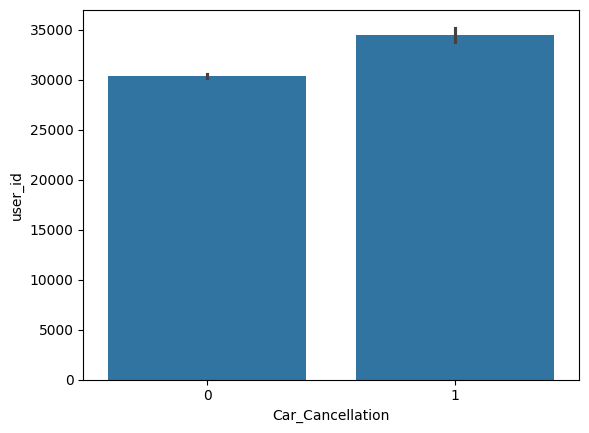

In [7]:
sns.barplot(taxi_df, x = "Car_Cancellation", y = "user_id")

### Looking into missing values

<Axes: >

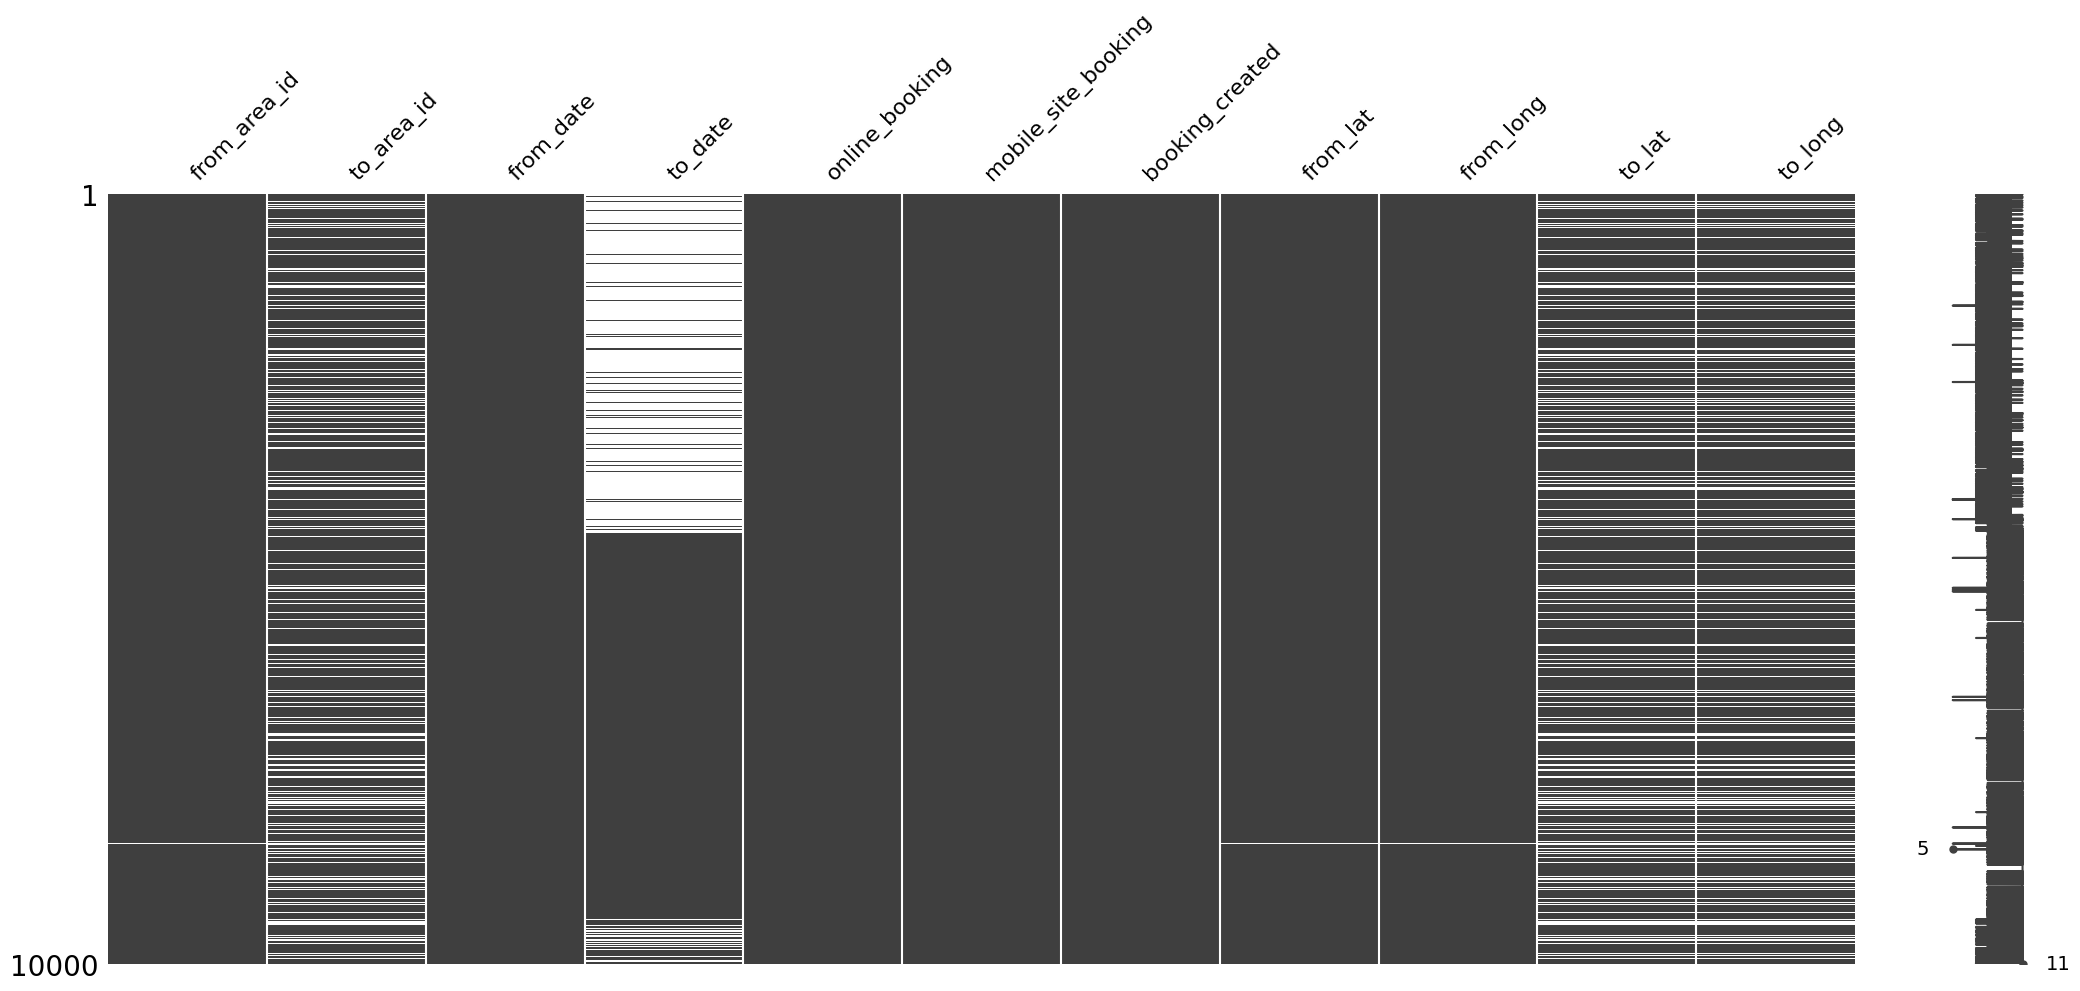

In [16]:
# This library help us visualize missing values :)
import missingno as msno
msno.matrix(taxi_df[taxi_df.columns[2:-1]])

In [11]:
# Percentage of missing values
missing_percentage = (taxi_df.isnull().sum() / len(taxi_df)) * 100

# Filter columns with missing values
missing_percentage = missing_percentage[missing_percentage > 0]
missing_percentage.sort_values(ascending=False)

to_city_id      96.61
package_id      82.48
from_city_id    62.94
to_date         41.78
to_area_id      20.91
to_lat          20.91
to_long         20.91
from_area_id     0.15
from_lat         0.15
from_long        0.15
dtype: float64

**Criteria for dropping the features: >70%**

**Imputing the missing values: <40-50%**

In [12]:
# Dropping the following features 'package_id', 'from_city_id', 'to_city_id'
# since they contain high volumn of missing values.
taxi_df.drop(['package_id', 'from_city_id', 'to_city_id'], axis = 1, inplace = True)

In [14]:
taxi_df.drop(['row#', 'user_id'], axis = 1, inplace = True)

In [15]:
taxi_df.columns

Index(['vehicle_model_id', 'travel_type_id', 'from_area_id', 'to_area_id',
       'from_date', 'to_date', 'online_booking', 'mobile_site_booking',
       'booking_created', 'from_lat', 'from_long', 'to_lat', 'to_long',
       'Car_Cancellation'],
      dtype='object')

### **Visualizing the distribution of Features by Car_Cancellation**

In [46]:
taxi_df.columns[2:-1].shape

(13,)

C:\Users\shyam\AppData\Local\Temp\ipykernel_4104\3620117480.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data = taxi_df, x = feature, hue = "Car_Cancellation", ax=axes[i], fill=True)


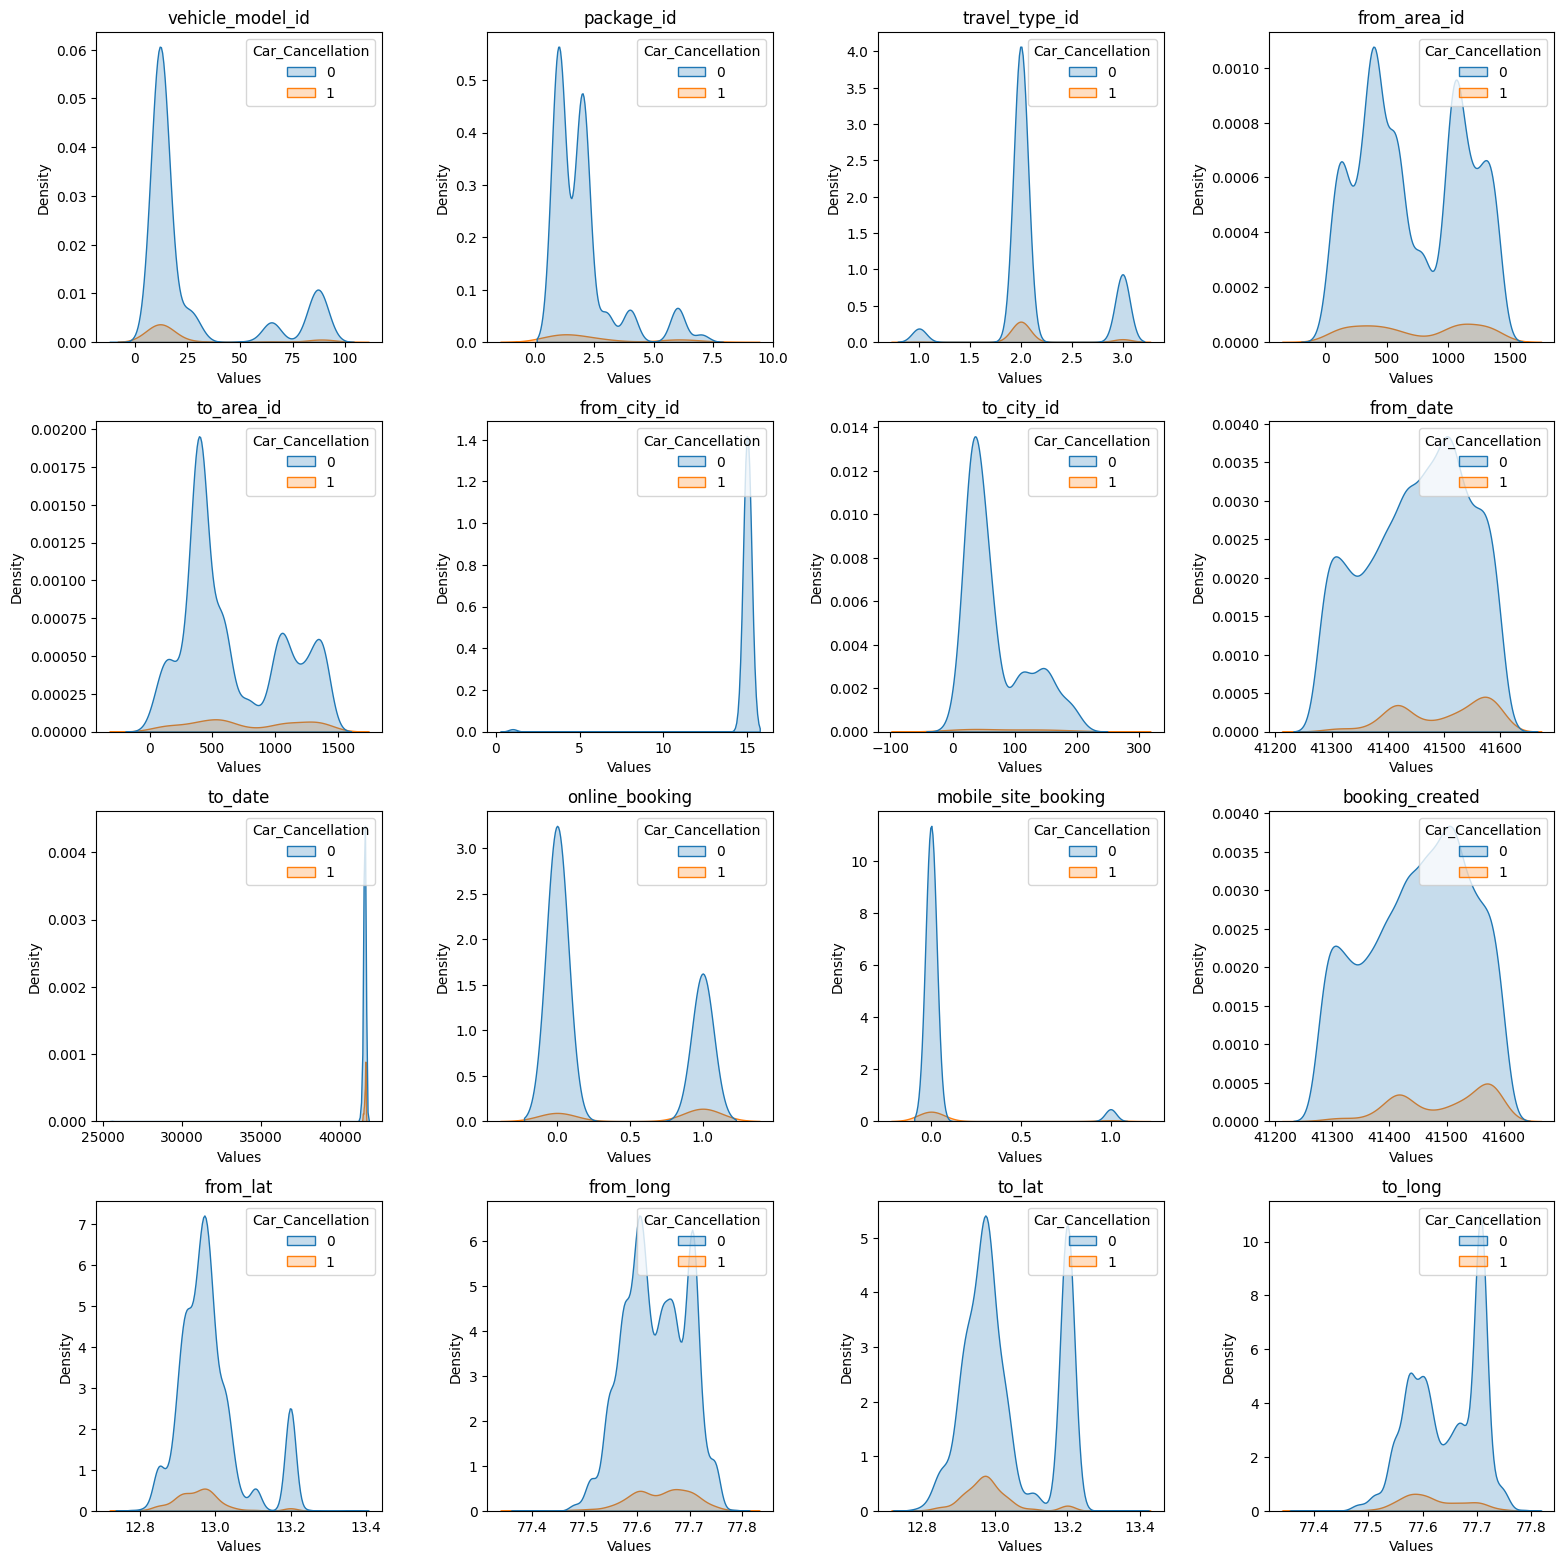

In [31]:
# Selecting the features to visualize their distribution
selected_features = taxi_df.columns[2:-1]

# Creating a 4x4 subplot 
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (16,16))
axes = axes.flatten()

for i, feature in enumerate(selected_features):
    sns.kdeplot(data = taxi_df, x = feature, hue = "Car_Cancellation", ax=axes[i], fill=True)
    axes[i].set_title(feature, fontsize=12)
    axes[i].set_xlabel('Values')
    axes[i].set_ylabel('Density')

plt.tight_layout(pad=2.0, h_pad=1.0)

## Train-Test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Standardizing the data

In [ ]:
# Scaling the data so that model can be train on features with same scale of value.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Developing the Neural Network

In [ ]:
model = Sequential([
    Dense( /, input_dim = , activation = 'relu'),
    Dense( /, input_dim = , activation = 'relu'),
    Dense( 2, input_dim = , activation = 'sigmoid'),
])